In [183]:
from load_data import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import pandas as pd
import numpy as np
import mpu
import matplotlib.pyplot as plt
import scipy.stats as st

In [184]:
prices, listings, reviews = load_data()

/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:54: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")


Data loaded.


/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:89: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  fil = listings["host_location"].str.contains(i, case = False, na = False)
/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/load_data.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_

Data cleansed.
Imputation done. No NaN's are left in the data.
Further Modifications are done.
Have fun implementing your models.


In [185]:
y = prices["log_price"].values/listings["accommodates"].values

Latitude and Longitude of Dublin City Center according to Google

In [186]:
dublin_cc = np.array([53.344053017257245, -6.267026698067987])

# Gaussian Process Regression

In [187]:
X = listings[["latitude", "longitude"]].values

In [188]:
def distance(a, b=dublin_cc):
    return mpu.haversine_distance(a, b)

In [189]:
X_dist = np.apply_along_axis(distance,1,X)

In [190]:
data = np.vstack((y,X_dist)).T
data = data[data[:, 1].argsort()]

y = data[:,0]
X = data[:,1].reshape(-1,1)

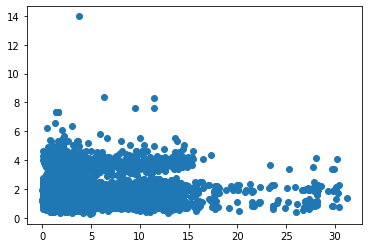

In [191]:
plt.scatter(X, y)

In [200]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=250, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [201]:
kernel = 1 * RBF(length_scale=1) * ConstantKernel() + 1 * ConstantKernel()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.0178**2 * RBF(length_scale=1e-05) * 51.1**2 + 0.474**2 * 4.21**2

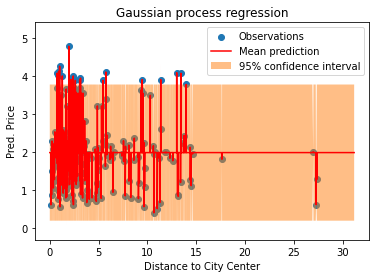

In [203]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction", color = "red")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("Distance to City Center")
plt.ylabel("Pred. Price")
_ = plt.title("Gaussian process regression")

No findings

Does the direction matter?

In [171]:
X1 = X[:,0]-dublin_cc[0]
X2 = X[:,1]-dublin_cc[1]
X = np.vstack((X1, X2)).T

In [173]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

Learned kernel 2.17**2 * RBF(length_scale=0.0238)


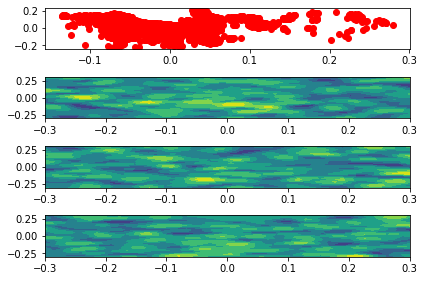

In [180]:
# Grid
lim = 0.3
res = 50
lin = np.linspace(-lim, lim, res)

# x1.shape = (50, 50)
x1, x2 = np.meshgrid(lin, lin)
# xx.shape = (2500, 2)
xx = np.vstack((x1.flatten(), x2.flatten())).T


kernel = 1*RBF()
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10)
gp.fit(X_train, y_train)
print("Learned kernel", gp.kernel_)
# y_mean.shape = (2500, )
# y_cov.shape = (2500, 2500)
y_mean, y_cov = gp.predict(xx, return_cov=True)

posterior_nums = 3
posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
                                        size=posterior_nums)

fig, axs = plt.subplots(posterior_nums+1)

ax = axs[0]
#ax.contourf(x1, x2, y_analytic)
ax.plot(X[:, 0], X[:, 1], "r.", ms=12)

for i, post in enumerate(posteriors, 1):
    axs[i].contourf(x1, x2, post.reshape(-1, res))

plt.tight_layout()
plt.show()

Doesn't seem like it does